In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from diffeqzoo import backend, ivps
from jax.config import config

from probdiffeq import dense_output, ivpsolve, solvers
from probdiffeq.implementations import recipes
from probdiffeq.strategies import smoothers

if not backend.has_been_selected:
    backend.select("jax")  # ivp examples in jax


config.update("jax_enable_x64", True)

In [5]:
# Make a problem
f, u0, (t0, t1), f_args = ivps.fitzhugh_nagumo(time_span=(0.0, 1.0))


@jax.jit
def vector_field(y, *, t, p):
    return f(y, *p)


# Make a solver
solver = solvers.DynamicSolver(smoothers.Smoother(recipes.IsoTS0.from_params()))

In [8]:
%%time
solution = ivpsolve.solve(
    vector_field,
    initial_values=(u0,),
    t0=t0,
    t1=t1,
    solver=solver,
    parameters=f_args,
)

CPU times: user 1.33 s, sys: 15 ms, total: 1.35 s
Wall time: 1.29 s


In [21]:
mesh = jnp.linspace(t0 + 1e-2, t1 - 1e-2, endpoint=True)

In [22]:
u, marginals = dense_output.offgrid_marginals_searchsorted(
    ts=mesh, solution=solution, solver=solver
)

In [29]:
m = marginals.hidden_state.mean
c_sqrtm = marginals.hidden_state.cov_sqrtm_lower
c = jnp.einsum("ijk,ikm->ijm", c_sqrtm, c_sqrtm)

In [40]:
v = jnp.diagonal(c, axis1=1, axis2=2)
s = jnp.sqrt(v)[:, 0]

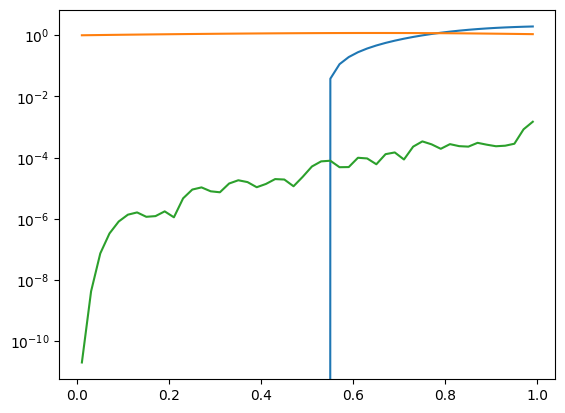

In [41]:
plt.plot(mesh, u)
plt.plot(mesh, u)
plt.semilogy(mesh, s)
plt.show()